In [1]:
from pathways.scenarios import run_scenarios, load_scenario_table
from pathways.simulation import load_configuration
from pathways.outputs import save_scenario_result_to_pandas

In [28]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [29]:
from pathlib import Path
datadir = Path("tests/test_summaries")
basic_config = load_configuration(datadir / "config.yml")
scenario_table = load_scenario_table(datadir / "validation_scenarios.csv")

In [30]:
# Separate the scenarios by validation category (infestation, sampling, and outcomes)
infest_validation_scenarios = scenario_table[0:16]
sample_validation_scenarios = scenario_table[16:36]
outcome_validation_scenarios = scenario_table[36:38]

# Infestation validation

### Test 1: Simulate 10 shipments with 10 boxes each (200 stems/box).
Check infestation rates and pest arrangement using combinations of:
* Fixed infestation rates - fixed values of 0.01, 0.1, 0.2
* Infestation unit - box or stem
* Pest arrangement - random or clustered (box infestation unit: 2 boxes max infested units, stem infestation unit: 200 stems max infested units and 400 stems max width)

### Test 2: Simulate 1000 shipments with 100 boxes each (200 stems/box), repeat for 20 iterations.
Check infestation rates using combinations of::
* Stochastic infestation rates - beta probability distribution using parameters [0.0194628, 2.7609372] (mean = 0.007, sd = 0.05)
* Infestation unit - box or stem
* Pest arrangement - random or clustered (box infestation unit: 2 boxes max infested units, stem infestation unit: 400 stems max infested units and 400 stems max width)

In [5]:
# Run Test 1
num_shipments_1 = 10
infest_validation_results_1, infest_validation_details_1 = run_scenarios(
    config=basic_config,
    scenario_table=infest_validation_scenarios[0:12],
    seed=42,
    num_simulations=1,
    num_shipments=num_shipments_1,
    detailed=True,
)

Running scenario: infest_validation_1
Running scenario: infest_validation_2
Running scenario: infest_validation_3
Running scenario: infest_validation_4
Running scenario: infest_validation_5
Running scenario: infest_validation_6
Running scenario: infest_validation_7
Running scenario: infest_validation_8
Running scenario: infest_validation_9
Running scenario: infest_validation_10
Running scenario: infest_validation_11
Running scenario: infest_validation_12


In [12]:
# Run Test 2
num_shipments_2 = 1000
infest_validation_results_2, infest_validation_details_2 = run_scenarios(
    config=basic_config,
    scenario_table=infest_validation_scenarios[12:16],
    seed=42,
    num_simulations=20,
    num_shipments=num_shipments_2,
    detailed=True,
)

Running scenario: infest_validation_13
Running scenario: infest_validation_14
Running scenario: infest_validation_15
Running scenario: infest_validation_16


In [13]:
# Save dataframe from test 1
infest_validation_df_1 = save_scenario_result_to_pandas(
    infest_validation_results_1,
    config_columns=[
        "shipment_name",
        "shipment/boxes/min",
        "shipment/boxes/max",
        "shipment/stems_per_box/default",
        "pest/infestation_unit",
        "pest/infestation_rate/distribution",
        "pest/infestation_rate/value",
        "pest/arrangement",
        "pest/clustered/distribution",
        "pest/clustered/max_infested_units_per_cluster",
        "pest/clustered/random/max_cluster_stem_width",
    ],
    result_columns=[
        "true_infestation_rate",
        "total_missed_pests",
    ],
)

In [14]:
# Save dataframe from test 2
infest_validation_df_2 = save_scenario_result_to_pandas(
    infest_validation_results_2,
    config_columns=[
        "shipment_name",
        "shipment/boxes/min",
        "shipment/boxes/max",
        "shipment/stems_per_box/default",
        "pest/infestation_unit",
        "pest/infestation_rate/distribution",
        "pest/infestation_rate/value",
        "pest/arrangement",
        "pest/clustered/distribution",
        "pest/clustered/max_infested_units_per_cluster",
        "pest/clustered/random/max_cluster_stem_width",
    ],
    result_columns=[
        "true_infestation_rate",
        "total_missed_pests",
    ],
)

## Check infestation rates

In [15]:
# Combine dataframes from both tests to view infestation rates
infest_validation_df = infest_validation_df_1.append(infest_validation_df_2)
infest_validation_df.index = range(len(infest_validation_df))


In [16]:
# Create table with expected and actual infestation rates
fixed_expected = infest_validation_df["pest/infestation_rate/value"][0:12]
beta_expected = pd.Series(0.007)
beta_expected = beta_expected.repeat(repeats=len(infest_validation_df_2))

expected_rates = fixed_expected.append(beta_expected)
expected_rates.index = range(len(expected_rates))
actual_rates = infest_validation_df["true_infestation_rate"]
scenarios = infest_validation_df["shipment_name"]

infestation_rate_validatation = pd.DataFrame({"scenarios": scenarios, "expected_rates": expected_rates, "actual_rates": actual_rates})

In [17]:
infestation_rate_validatation

,scenarios,expected_rates,actual_rates
0,clustered_stem_0.01,0.01,0.010000
1,random_stem_0.01,0.01,0.010000
2,clustered_box_0.01,0.01,0.000000
3,random_box_0.01,0.01,0.000000
4,clustered_stem_0.1,0.1,0.100000
5,random_stem_0.1,0.1,0.100000
6,clustered_box_0.1,0.1,0.100000
7,random_box_0.1,0.1,0.100000
8,clustered_stem_0.2,0.2,0.200000
9,random_stem_0.2,0.2,0.200000


The true infestation rates for the fixed values are all exactly as expected except for when using the box infestation unit with a low infestation rate (0.01), which results in 0 actual infestation rate. This is because the number of boxes infested is rounded to the nearest integer, which is 0 in this case since the infestation rate is so low.

The stochastic infestation rates are all very close to expected average rate. The lower rate with the box units is likely due to rounding to the nearest integer, which will be 0 often with such low rates.

## Check pest arrangements

In [18]:
# Use stems from only the test 1 shipments (smaller shipments for easier visualization)
infest_validation_stems_unstacked = [i[0] for i in infest_validation_details_1]

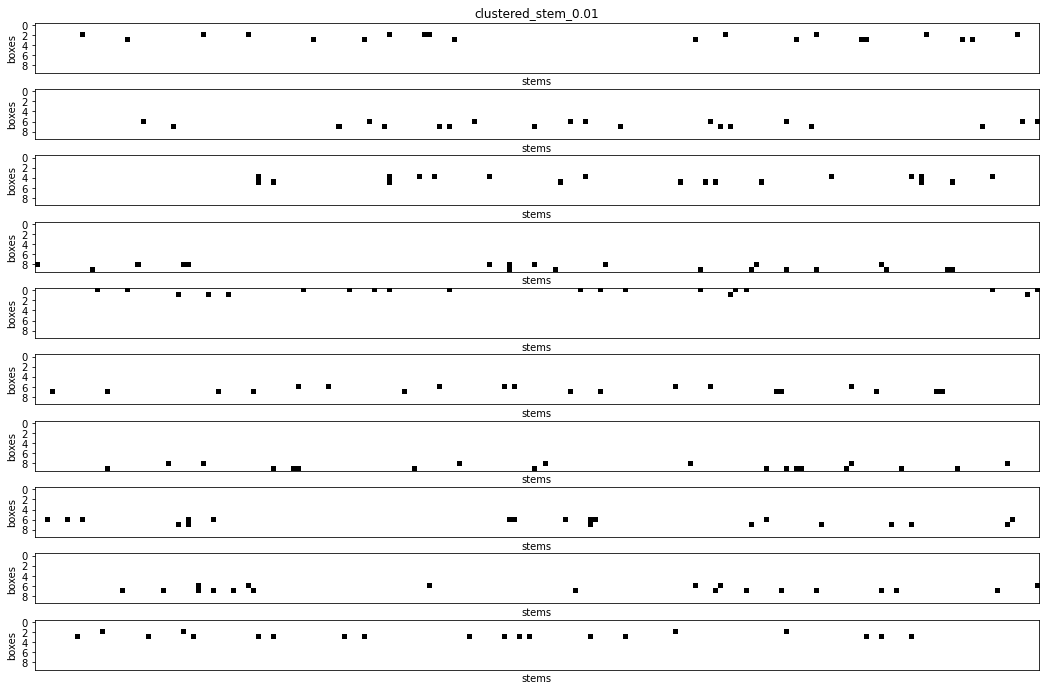

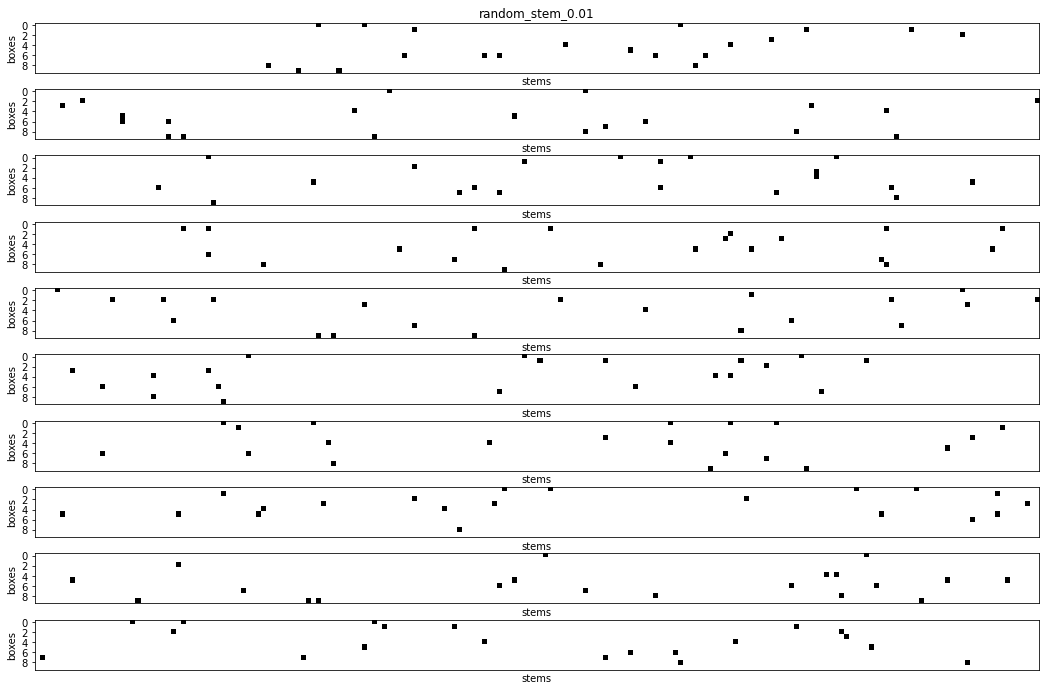

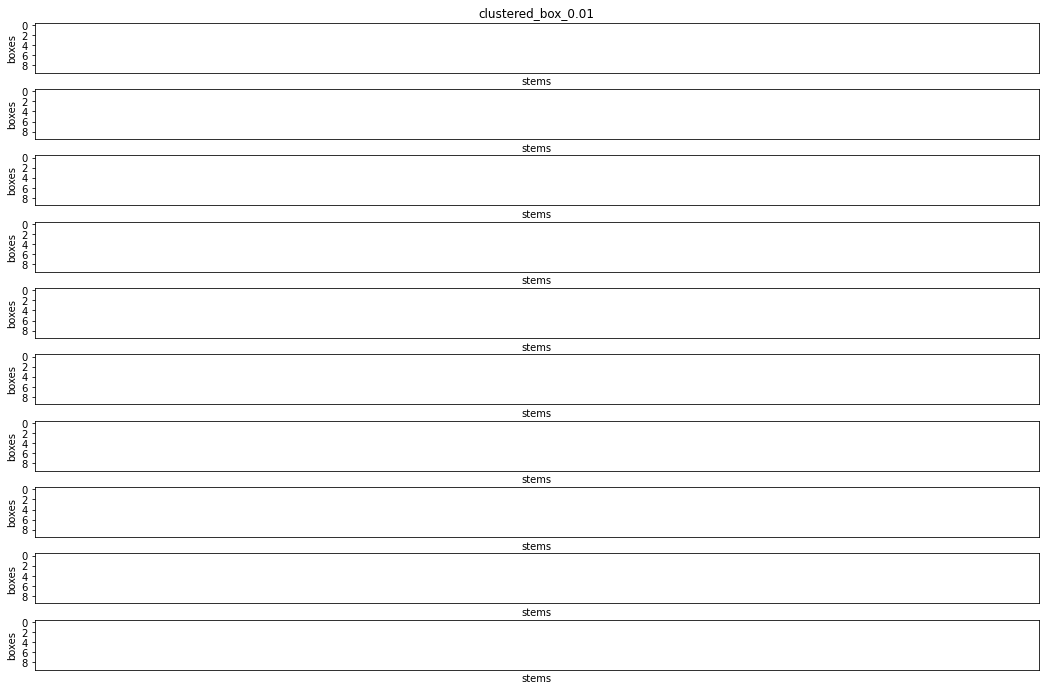

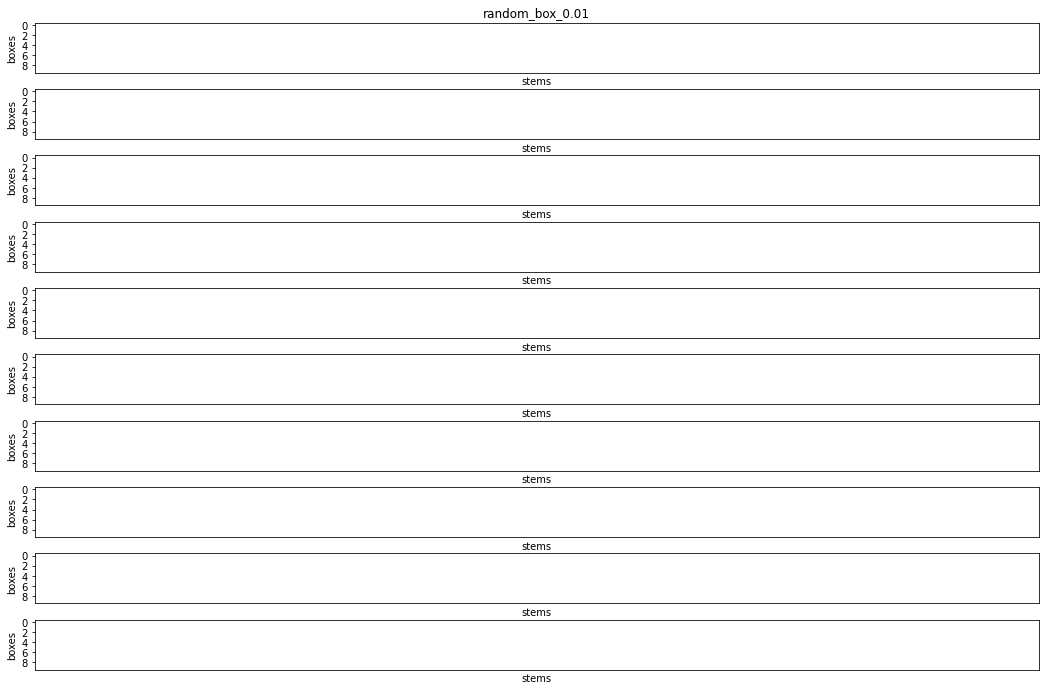

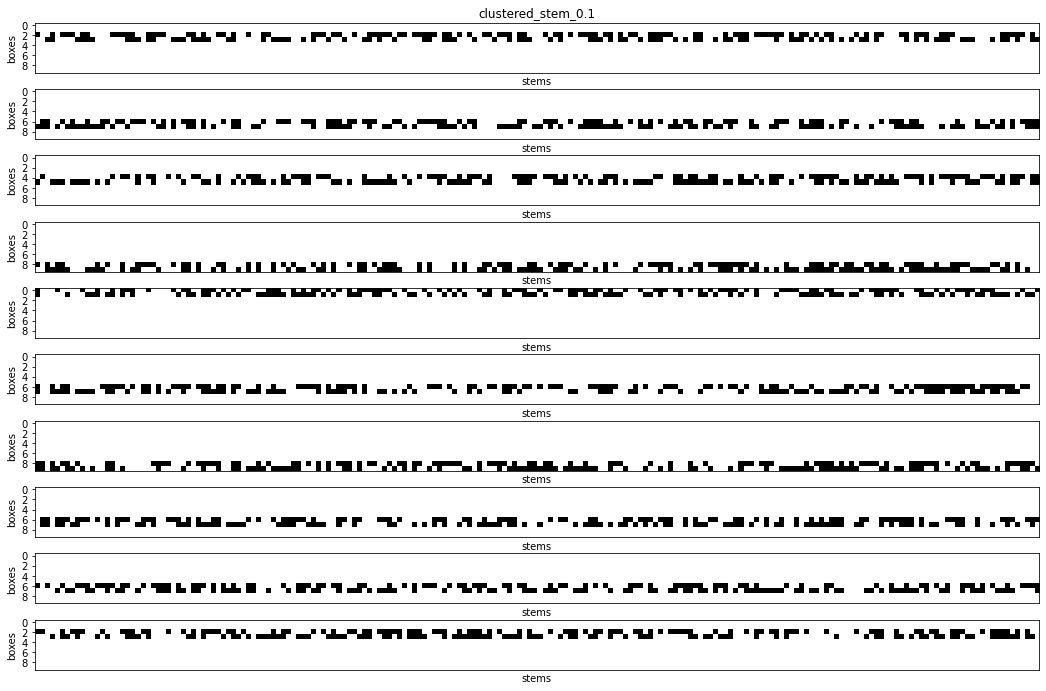

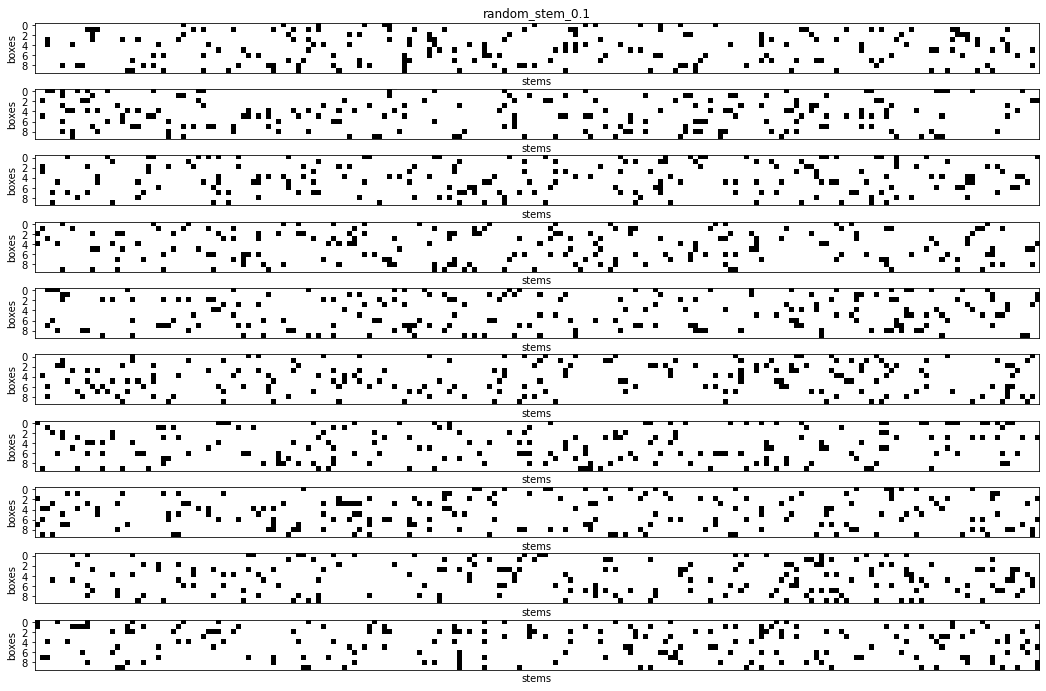

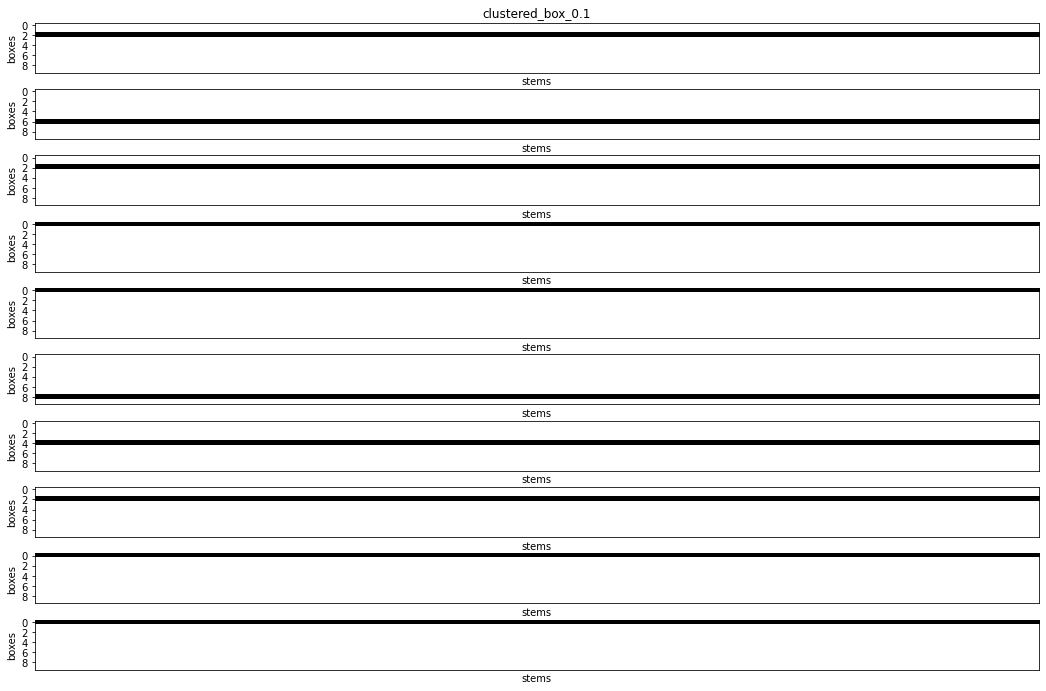

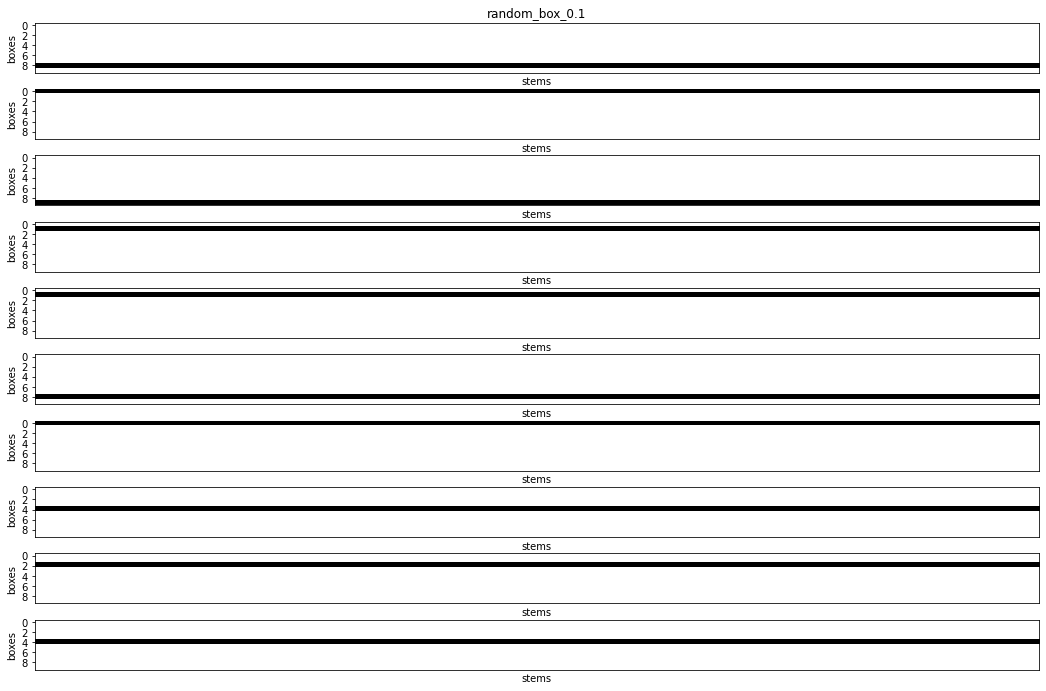

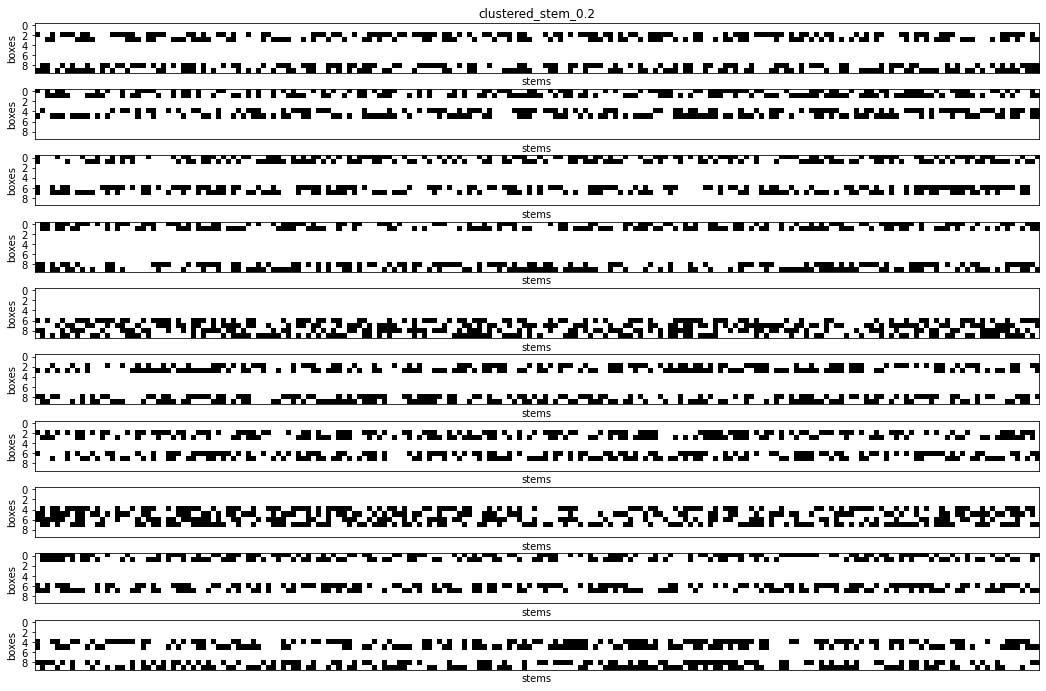

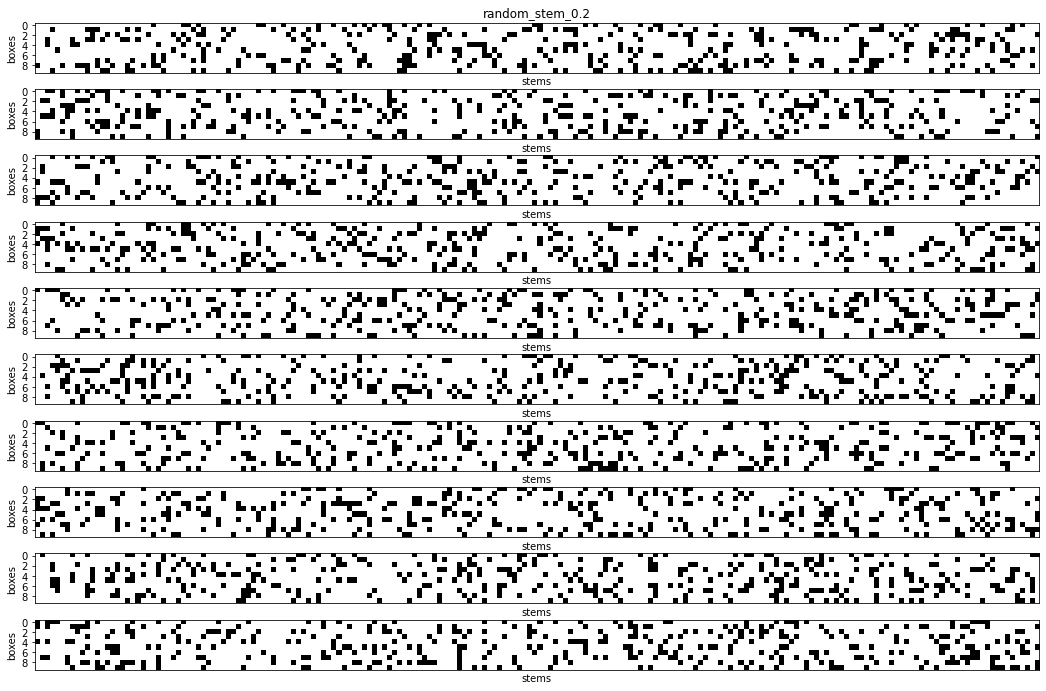

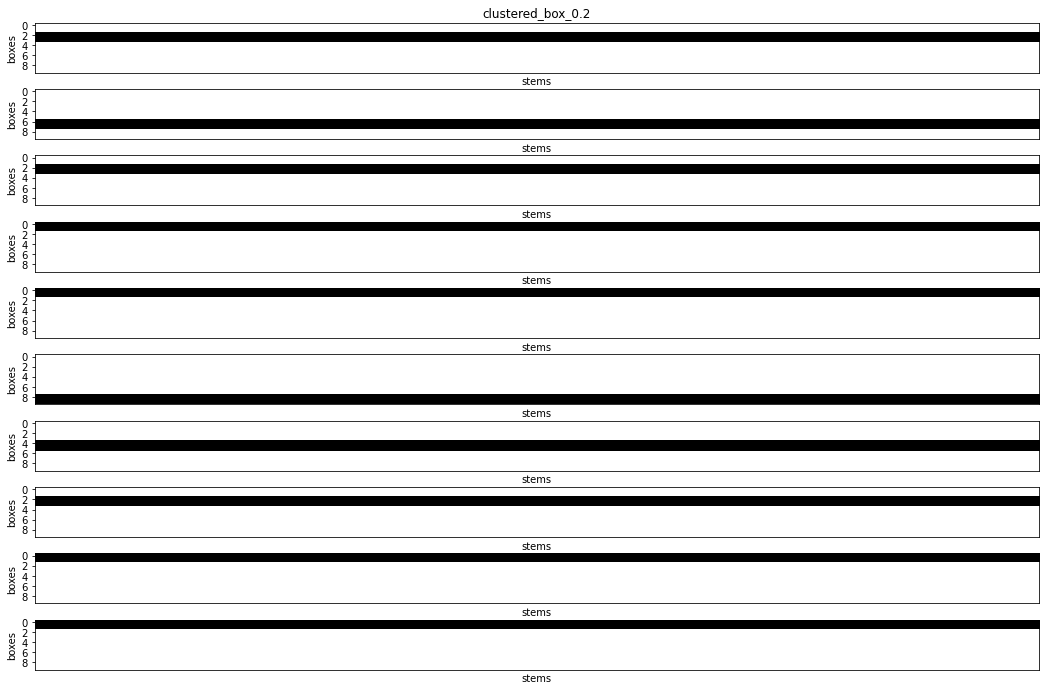

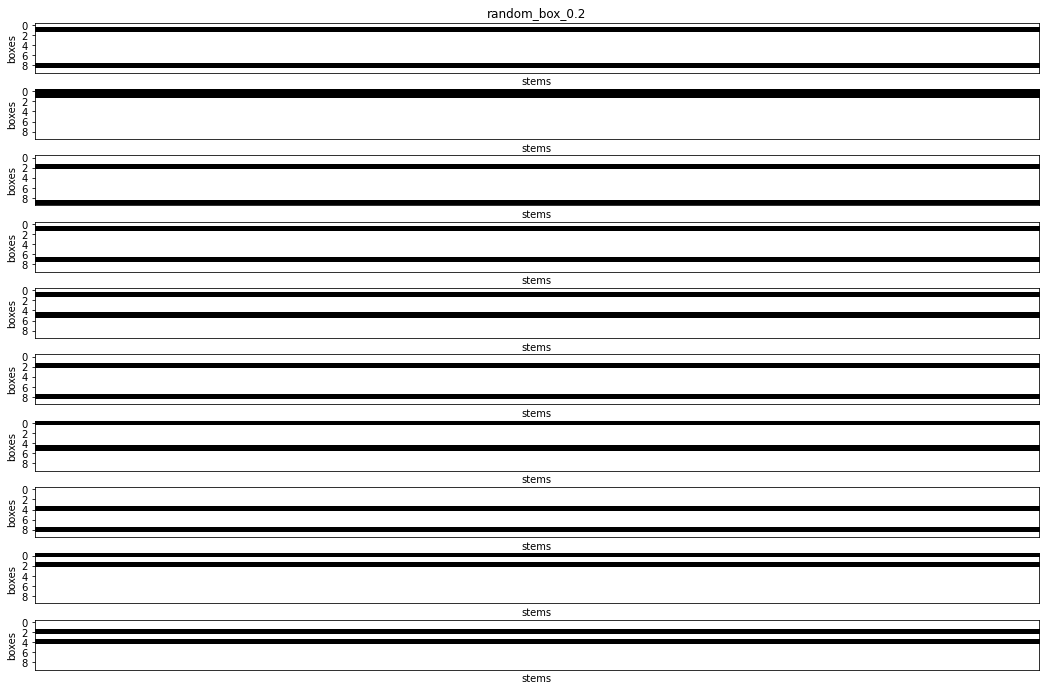

In [19]:
# Plot stems for each scenario and check pest arrangement and infestation unit

scenarios = infest_validation_df_1["shipment_name"]

for index, scenario in enumerate(scenarios):
    infest_validation_stems = np.stack(infest_validation_stems_unstacked[index])
    stems_by_shipment = np.vsplit(infest_validation_stems, num_shipments_1)
    fig, axs = plt.subplots(len(stems_by_shipment), figsize=(18,12))
    for i in range(len(stems_by_shipment)):
        axs[i].matshow(stems_by_shipment[i], cmap='Greys')
        axs[i].set_ylabel('boxes')
        axs[i].set_xlabel('stems')
        axs[i].tick_params(labeltop=False, top=False, bottom=False)
        if i == 0:
            axs[i].set_title(scenario)

The shipments using stems as the infestation unit and clustered arrangement use maximum of 200 infested stems per cluster and are spread across 400 stems (2 boxes).

The shipments using boxes as the infestation unit and clustered arrangement use maximum 2 boxes per cluster.

# Sampling validation

### Test: Simulate 1 shipment, using 1 iteration.
Check sample size and indexes inspected using combinations of:
* Number of boxes - 10 or 100 (50 stems/box)
* Sampling unit - box or stems
* Sample size calculation method - proportion or hypergeometric
* Sample selection method - random, convenience, or cluster (inspecting 25% of every 3rd box)

In [31]:
num_shipments = 1
sample_validation_results, sample_validation_details = run_scenarios(
    config=basic_config,
    scenario_table=sample_validation_scenarios,
    seed=42,
    num_simulations=1,
    num_shipments=num_shipments,
    detailed=True,
)

Running scenario: sample_validation_1
Running scenario: sample_validation_2
Running scenario: sample_validation_3
Running scenario: sample_validation_4
Running scenario: sample_validation_5
Running scenario: sample_validation_6
Running scenario: sample_validation_7
Running scenario: sample_validation_8
Running scenario: sample_validation_9
Running scenario: sample_validation_10
Running scenario: sample_validation_11
Running scenario: sample_validation_12
Running scenario: sample_validation_13
Running scenario: sample_validation_14
Running scenario: sample_validation_15
Running scenario: sample_validation_16
Running scenario: sample_validation_17
Running scenario: sample_validation_18
Running scenario: sample_validation_19
Running scenario: sample_validation_20


In [33]:
sample_validation_df = save_scenario_result_to_pandas(
    sample_validation_results,
    config_columns=[
        "inspection_name",
        "shipment/boxes/min",
        "shipment/boxes/max",
        "shipment/stems_per_box/default",
        "inspection/unit",
        "inspection/sample_strategy",
        "inspection/proportion/value",
        "inspection/hypergeometric/detection_level",
        "inspection/selection_strategy",
    ],
    result_columns=[
        "avg_boxes_opened_completion",
        "avg_stems_inspected_completion",
    ],
)

,inspection_name,shipment/boxes/min,shipment/boxes/max,shipment/stems_per_box/default,inspection/unit,inspection/sample_strategy,inspection/proportion/value,inspection/hypergeometric/detection_level,inspection/selection_strategy,avg_boxes_opened_completion,avg_stems_inspected_completion
0,stem_hypergeometric_random,10,10,50,stems,hypergeometric,,0.01,random,10.0,225.0
1,stem_hypergeometric_tailgate,10,10,50,stems,hypergeometric,,0.01,tailgate,5.0,225.0
2,stem_hypergeometric_hierarchical,10,10,50,stems,hypergeometric,,0.01,hierarchical,5.0,225.0
3,stem_proportion_random,10,10,50,stems,proportion,0.02,,random,7.0,10.0
4,stem_proportion_tailgate,10,10,50,stems,proportion,0.02,,tailgate,1.0,10.0
5,stem_proportion_hierarchical,10,10,50,stems,proportion,0.02,,hierarchical,1.0,10.0
6,box_hypergeometric_random,10,10,50,boxes,hypergeometric,,0.01,random,10.0,500.0
7,box_hypergeometric_tailgate,10,10,50,boxes,hypergeometric,,0.01,tailgate,10.0,500.0
8,box_proportion_random,10,10,50,boxes,proportion,0.02,,random,0.0,0.0
9,box_proportion_tailgate,10,10,50,boxes,proportion,0.02,,tailgate,0.0,0.0


## Check sample sizes

In [76]:
expected_stem_sample_sizes = np.array([225, 225, 225, 10, 10, 10, 500, 500, 0, 0, 290, 290, 290, 100, 100, 100, 4750, 4750, 100, 100])
actual_stem_sample_sized = sample_validation_df["avg_stems_inspected_completion"]
scenarios = sample_validation_df["inspection_name"]

sample_size_validatation = pd.DataFrame({"scenarios": scenarios, "expected_stem_sample_sizes": expected_stem_sample_sizes, "actual_stem_sample_sized": actual_stem_sample_sized})


In [77]:
sample_size_validatation

,scenarios,expected_stem_sample_sizes,actual_stem_sample_sized
0,stem_hypergeometric_random,225,225.0
1,stem_hypergeometric_tailgate,225,225.0
2,stem_hypergeometric_hierarchical,225,225.0
3,stem_proportion_random,10,10.0
4,stem_proportion_tailgate,10,10.0
5,stem_proportion_hierarchical,10,10.0
6,box_hypergeometric_random,500,500.0
7,box_hypergeometric_tailgate,500,500.0
8,box_proportion_random,0,0.0
9,box_proportion_tailgate,0,0.0


## Check sample selection

In [35]:
sample_validation_inspected_indexes = [i[1] for i in sample_validation_details[0:10]]

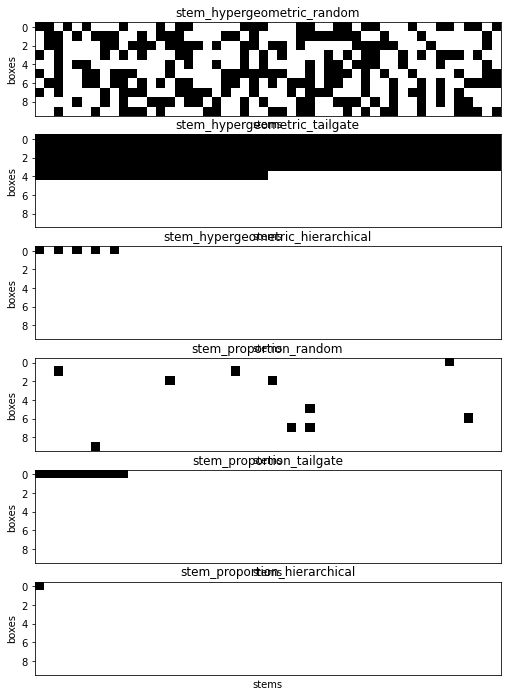

In [64]:
stem_scenarios = sample_validation_df[0:6]["inspection_name"]

fig, axs = plt.subplots(len(stem_scenarios), figsize=(18,12))
for i in range(len(stem_scenarios)):
    indexes = np.zeros(500, dtype=np.int)
    inpsected = sample_validation_inspected_indexes[i][0]
    np.put(indexes, inpsected, 1)
    indexes = np.array_split(indexes, 10)
    axs[i].matshow(indexes, cmap='Greys')
    axs[i].set_ylabel('boxes')
    axs[i].set_xlabel('stems')
    axs[i].tick_params(labeltop=False, top=False, bottom=False)
    axs[i].set_title(stem_scenarios[i])

In [ ]:
num_shipments = 10000
outcome_validation_results, outcome_validation_details = run_scenarios(
    config=basic_config,
    scenario_table=outcome_validation_scenarios,
    seed=42,
    num_simulations=1,
    num_shipments=num_shipments,
    detailed=True,
)

In [ ]:
outcome_validation_df = save_scenario_result_to_pandas(
    outcome_validation_results,
    config_columns=[
        "name",
        "shipment/boxes/min",
        "shipment/boxes/max",
        "shipment/stems_per_box/default",
        "pest/infestation_unit",
        "pest/infestation_rate/distribution",
        "pest/infestation_rate/value",
        "pest/arrangement",
        "inspection/unit",
        "inspection/sample_strategy",
    ],
    result_columns=[
        "true_infestation_rate",
        "false_neg",
        "intercepted",
        "total_missed_pests",
        "total_intercepted_pests",
        "avg_boxes_opened_completion",
        "avg_stems_inspected_completion",
    ],
)
outcome_validation_df

In [ ]:
df['shipment_name'] = pd.Categorical(df['shipment_name'])
shipment_order = ["infestation_5", "infestation_10", "infestation_25", "small", "large", "maritime", "clustered", "clustered_small", "clustered_large"]
df['shipment_name'] = df['shipment_name'].cat.reorder_categories(shipment_order, ordered=True)
df

In [ ]:
df.plot(kind="bar", x="inspection_name", y="missing")

In [ ]:
#df["shipment"] = df.apply(lambda row: re.sub("_[0-9]+$", "", row["name"]), axis = 1)

In [ ]:
df.groupby("shipment_name").agg({"missing": "mean"}).reset_index().plot(kind="bar", x="shipment_name", y="missing")

In [ ]:
df.groupby("inspection_name").agg({"missing": "mean"}).reset_index().plot(kind="bar", x="inspection_name", y="missing")
plt.xlabel("inspection", size=12)
plt.ylabel("percent missed", size=12)
plt.title("Avg percent infested shipments missed by inspection", size=16)

In [ ]:
inspections_vs_shipments = df.pivot_table(index=["inspection_name"], columns=["shipment_name"], values=["missing"])
inspections_vs_shipments

In [ ]:
inspections_vs_shipments.plot(kind="bar")

In [ ]:
ax = inspections_vs_shipments.plot(kind="bar", figsize=(100, 10))
#ax.figure.savefig("inspections_vs_shipments_bar.png")

In [ ]:
from itertools import cycle, islice

it = cycle(list(range(1,49)))
df['inspection_num'] = list(islice(it, len(df)))

In [ ]:
plt.figure(figsize=(30, 8))
sns.boxplot(x="inspection_name", y="missing", data=df)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.xlabel("inspection", size=16)
plt.ylabel("percent missed", size=16)
plt.title("Avg. percent infested shipments missed by inspection", size=20)
plt.savefig("missed_by_inspection_boxplot.png", bbox_inches = "tight")

In [ ]:
plt.figure(figsize=(30, 8))
sns.barplot(x="inspection_name", y="missing", data=df)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.xlabel("inspection", size=16)
plt.ylabel("percent missed", size=16)
plt.title("Avg. percent infested shipments missed by inspection", size=20)
plt.savefig("missed_by_inspection.png", bbox_inches = "tight")

In [ ]:
sns.barplot(x="shipment_name", y="missing", data=df)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.xlabel("shipment type", size=12)
plt.ylabel("percent missed", size=12)
plt.title("Avg. percent infested shipments missed by shipment type", size=16)
plt.savefig("missed_by_shipment.png", bbox_inches = "tight")

In [ ]:
sns.boxplot(x="shipment_name", y="missing", data=df)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.xlabel("shipment type", size=12)
plt.ylabel("percent missed", size=12)
plt.title("Percent infested shipments missed by shipment type", size=16)
plt.savefig("missed_by_inspection_boxplot.png", bbox_inches = "tight")

In [ ]:
sns.catplot(x="shipment_name", y="missing", hue="inspection/sample_strategy", kind="box", data=df, height=8.27, aspect=11.7/8.27)
plt.xlabel("shipment type", size=12)
plt.ylabel("percent missed", size=12)
plt.title("Percent infested shipments missed by shipment type and sample strategy", size=16)
plt.savefig("missed_by_shipment_sample_strategy.png", bbox_inches = "tight")

In [ ]:
sns.catplot(x="shipment_name", y="missing", hue="inspection/unit", kind="box", data=df, height=9, aspect=11.7/8.27)
plt.xlabel("shipment type", size=12)
plt.ylabel("percent missed", size=12)
plt.title("Percent infested shipments missed by shipment type and inspection unit", size=16)
plt.savefig("missed_by_shipment_unit.png", bbox_inches = "tight")

In [ ]:
chart = sns.catplot(x="shipment_name", y="missing", hue="inspection/selection_strategy", aspect=11.7/8.27,
            kind="box", data=df, height=8)
chart.set_xticklabels(rotation=65, horizontalalignment='right')
plt.xlabel("shipment type", size=12)
plt.ylabel("percent missed", size=12)
plt.title("Percent infested shipments missed by shipment type and selection strategy", size=16)
chart.savefig("missed_by_shipment_selection.png", bbox_inches = "tight")

In [ ]:
inspections_vs_shipments

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(data=inspections_vs_shipments, annot=True, fmt=".2f", xticklabels = shipment_order)
plt.xlabel("shipment type", size=12)
plt.ylabel("inspection", size=12)
plt.title("Percent infested shipments missed", size=16)
plt.savefig("heatmap_missed.png", bbox_inches = "tight")

In [ ]:
inspections_vs_shipments_boxes_opened = df.pivot_table(index=["inspection_name"], columns=["shipment_name"], values=["avg_boxes_opened_completion"])

plt.figure(figsize=(10, 10))
sns.heatmap(data=inspections_vs_shipments_boxes_opened, annot=True, fmt=".2f", xticklabels = shipment_order)
plt.xlabel("shipment type", size=12)
plt.ylabel("inspection", size=12)
plt.title("Avg. number of boxes opened (inspect to completion)", size=16)
plt.savefig("heatmap_boxes_completion.png", bbox_inches = "tight")

In [ ]:
inspections_vs_shipments_stems_inspected = df.pivot_table(index=["inspection_name"], columns=["shipment_name"], values=["avg_stems_inspected_completion"])

plt.figure(figsize=(10, 10))
sns.heatmap(data=inspections_vs_shipments_stems_inspected, annot=True, fmt=".2f", xticklabels = shipment_order)
plt.xlabel("shipment type", size=12)
plt.ylabel("inspection", size=12)
plt.title("Avg. number of stems inpected (inspect to completion)", size=16)
plt.savefig("heatmap_stems_completion.png", bbox_inches = "tight")

In [ ]:
inspections_vs_shipments_boxes_opened_detection = df.pivot_table(index=["inspection_name"], columns=["shipment_name"], values=["avg_boxes_opened_detection"])

plt.figure(figsize=(10, 10))
sns.heatmap(data=inspections_vs_shipments_boxes_opened_detection, annot=True, fmt=".2f", xticklabels = shipment_order)
plt.xlabel("shipment type", size=12)
plt.ylabel("inspection", size=12)
plt.title("Avg. number of boxes opened (inspect to detection)", size=16)
plt.savefig("heatmap_boxes_detection.png", bbox_inches = "tight")

In [ ]:
inspections_vs_shipments_stems_inspected_detection = df.pivot_table(index=["inspection_name"], columns=["shipment_name"], values=["avg_stems_inspected_detection"])

plt.figure(figsize=(10, 10))
sns.heatmap(data=inspections_vs_shipments_stems_inspected_detection, annot=True, fmt=".2f", xticklabels = shipment_order)
plt.xlabel("shipment type", size=12)
plt.ylabel("inspection", size=12)
plt.title("Avg. number of stems inspected (inspect to detection)", size=16)
plt.savefig("heatmap_stems_detection.png", bbox_inches = "tight")

In [ ]:
df_norm = df[["missing",
        "true_infestation_rate",
        "max_intercepted_infestation_rate",
        "avg_intercepted_infestation_rate",
        "avg_boxes_opened_completion",
        "avg_boxes_opened_detection",
        "avg_stems_inspected_completion",
        "avg_stems_inspected_detection",
        "pct_sample_if_to_detection",
        "pct_pest_unreported_if_detection"]]
df_norm

In [ ]:
df_norm=(df_norm-df_norm.min())/(df_norm.max()-df_norm.min())
df_norm

In [ ]:
df_norm["name"], df_norm["inspection_num"], df_norm["inspection_name"], df_norm["shipment_name"] = df["name"], df["inspection_num"], df["inspection_name"], df["shipment_name"]
df_norm

In [ ]:
df_norm_melted = pd.melt(df_norm, id_vars=["inspection_num", "inspection_name", "shipment_name"], value_vars=["missing", "avg_boxes_opened_completion", "avg_stems_inspected_completion"])
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted, ax=ax1, ci = None)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (mean value across all shipment types)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_all.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("infestation_5")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (5% Infestation shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_infestation_5.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("infestation_10")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (10% Infestation shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_infestation_10.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("infestation_25")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (25% Infestation shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_infestation_25.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("small")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (Small shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_small.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("large")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (Large shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_large.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("maritime")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (Maritime shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_maritime.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("clustered")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (Clustered shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_clustered.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("clustered_small")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (Clustered small shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_clustered_small.png", bbox_inches = "tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6))
chart = sns.barplot(x="inspection_name", y="value", hue="variable",\
                data=df_norm_melted[df_norm_melted.shipment_name.eq("clustered_large")], ax=ax1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title("Normalized metrics by inspection (Clustered large shipments)")
plt.xlabel("inspection description")
plt.ylabel("normalized value")
plt.savefig("metrics_by_inspection_clustered_large.png", bbox_inches = "tight")